# Предсказание дебита жидкости нефтяных скважин методами линейной регрессии и регрессионных деревьев

В данной работе будет произведено предсказание на месяц дебита жидкости для каждой из скважин датасета.

# Описание данных
Датасет содержит данные о характеристиках нефтяных скважин. Набор данных включает следующие поля:
- `Скважина` — номер нефтяной скважины,
- `Дата` — дата снятия показаний,
- `Забойное давление` — рабочее давление скважины,
- `Дебит жидкости` — характеристика жидкости,
- `Дебит нефти` — характеристика нефти,
- `Обводненность`.

In [1]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
bores_df = pd.read_excel('bores_df.xlsx')

In [3]:
bores_df.head()

,Скважина,Дата,Забойное давление,Дебит жидкости,Дебит нефти,Обводненность
0,1,1999-01-01,37.994385,8.0,7.2,0.1
1,1,1999-01-02,37.994385,8.0,7.2,0.1
2,1,1999-01-03,37.994385,8.0,7.2,0.1
3,1,1999-01-04,37.784920,7.0,6.3,0.1
4,1,1999-01-05,37.784920,7.0,6.3,0.1


In [4]:
bores_df.dtypes

Скважина                      int64
Дата                 datetime64[ns]
Забойное давление           float64
Дебит жидкости              float64
Дебит нефти                 float64
Обводненность               float64
dtype: object

Приведение даты к типу datetime

In [5]:
bores_df['Дата'] = pd.to_datetime(bores_df['Дата'], format='%Y-%m-%d', errors='coerce')

Функция извлечения исследуемой скважины:

In [6]:
def num_bore(df, num):
    return df.loc[df['Скважина'] == num]

In [7]:
print(f'Введите номер скважины из доступных: {bores_df["Скважина"].unique()}')
bore = num_bore(bores_df, int(input()))
date = bore['Дата'][-30:].reset_index().drop('index', axis=1) #месяц, для которого будет производиться предсказание
bore = bore.set_index(bore['Дата'])
bore = bore.drop(['Скважина','Дата'], axis=1)

Введите номер скважины из доступных: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
1


<AxesSubplot:>

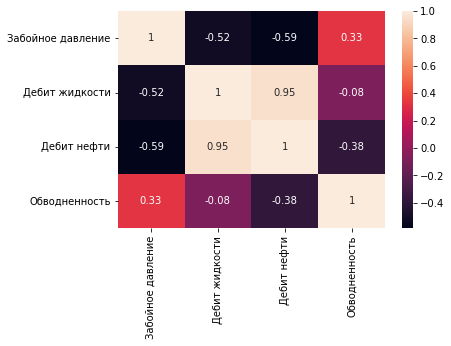

In [8]:
sns.heatmap(bore.corr(), annot=True)
#Дебит нефти = дебит жидкости - дебит жидкости*обводнённость

Из тепловой карты выше, можно увижеть сильную положительную корреляцию дебита жидкости и дебита нефти,
а также значимые отрицательльные корреляции дебита жидкости с забойным давлением и забойного давления с дебитом нефти

Посмотрим распределение дебита жидкости по времени

<AxesSubplot:xlabel='Дата'>

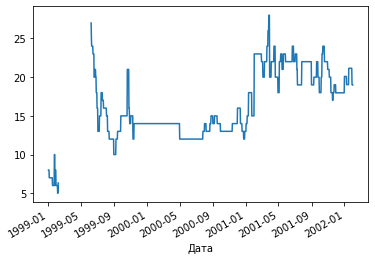

In [9]:
bore['Дебит жидкости'].plot()

Из представленного выше распределения видны пропущенные значения, посчитаем их количество

In [10]:
bore.isnull().sum()

Забойное давление    121
Дебит жидкости       121
Дебит нефти          121
Обводненность        121
dtype: int64

Эти значения обуславливаются выводом скважины из строя, поэтому заменим их нулями

In [11]:
bore = bore.fillna(0)

Подготовим обучающие и тестовые выборки для дальнейшего обучения модели:

In [12]:
X = bore[['Забойное давление','Дебит нефти']]
y = bore['Дебит жидкости']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X[:-30], #последние 30 значений оставляем на задачу предсказания
                                                    y[:-30], #последние 30 значения оставляем на проверку предсказания
                                                    test_size=0.25,
                                                    random_state=42)

Создадим две модели обучения: методом линейной регрессии и методом регрессионного дерева

In [14]:
lr = LinearRegression()
dtr = tree.DecisionTreeRegressor()

Обучим модель линейной регресии и посмотрим на коэффициент детерминации

In [15]:
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.9711931081969657

Обучим модель регрессионного дерева и посмотрим на коэффициент детерминации

In [16]:
parameters = {'criterion': ['friedman_mse', 'poisson'], #параметры были выбраны исходя из возможного переобучения дерева
             'max_depth': range(1,20),
             'min_samples_split': range(10,100,10),
             'min_samples_leaf': range(10,100,10)}

In [17]:
grid_search_cv_reg = GridSearchCV(dtr, parameters, cv=5)

In [18]:
grid_search_cv_reg.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['friedman_mse', 'poisson'],
                         'max_depth': range(1, 20),
                         'min_samples_leaf': range(10, 100, 10),
                         'min_samples_split': range(10, 100, 10)})

In [19]:
grid_search_cv_reg.best_params_ #посмотрим на лучшие параметры дерева

{'criterion': 'friedman_mse',
 'max_depth': 10,
 'min_samples_leaf': 10,
 'min_samples_split': 50}

In [20]:
tree_reg = grid_search_cv_reg.best_estimator_ #передадим лучшие параметры нашей новой модели

In [21]:
tree_reg.score(X_test, y_test)

0.9685635715011509

Сделаем предсказание на 30 дней и построим графики для ознакомления с результатом обучения

In [22]:
y_pred_lr = pd.DataFrame({'Дебит жидкости':lr.predict(X[-30:])}) #предсказание линейной регрессией
y_pred_dtr = pd.DataFrame({'Дебит жидкости':tree_reg.predict(X[-30:])}) #предсказание регрессионным деревом

In [23]:
pred_lr = date.join(y_pred_lr)
pred_lr = pred_lr.set_index(pred_lr['Дата']).drop('Дата', axis=1)
pred_dtr = date.join(y_pred_dtr)
pred_dtr = pred_dtr.set_index(pred_dtr['Дата']).drop('Дата', axis=1)

In [24]:
def pred(series, series_lr, series_dtr, n, plot_bounds=False):
    roll_mean = series.rolling(n, min_periods=1).mean()
    fig, ax = plt.subplots(figsize=(15, 5))
    plt.title('График распределения дебита жидкости')
    plt.plot(roll_mean, 'r', label=f'Сглаженный дебит жидкости за {n} дней')
    plt.plot(series, 'g--', label='Дебит жидкости')
    plt.plot(series_lr, 'b--', label='Предсказанный дебит жидкости линейной регрессией')
    plt.plot(series_dtr, 'm--', label='Предсказанный дебит жидкости регрессионным деревом')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.xticks(rotation=45)
    pass

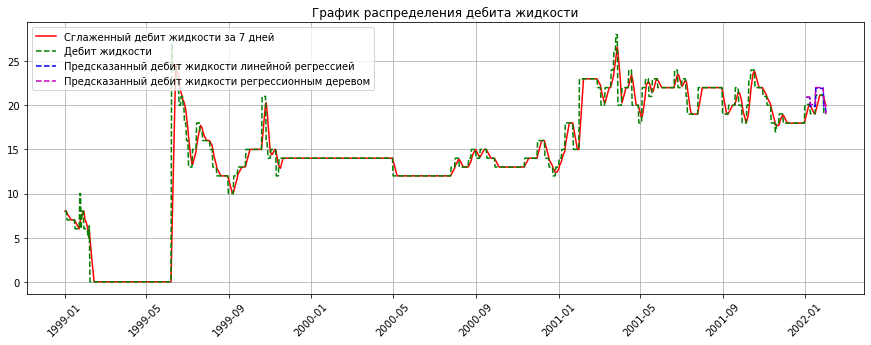

In [25]:
pred(bore['Дебит жидкости'], pred_lr, pred_dtr, 7)